In [1]:
import glob  #glob 모듈의 glob 함수는 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환한다
import tensorflow

print(tensorflow.__version__)

2.6.0


# Step 1. 데이터 다운로드
---
앞부분에서 로드 함.

# Step 2. 데이터 읽어오기
---
glob 모듈을 사용하면 파일을 읽어오는 작업을 하기가 아주 용이함. 
glob 를 활용하여 모든 txt 파일을 읽어온 후, raw_corpus 리스트에 문장 단위로 저장.

In [2]:
import glob
import os, re
txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*' #os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. txt_file_path 에 "/root/aiffel/lyricist/data/lyrics/*" 저장

#txt_file_path 경로에 있는 모든 파일명을 리스트 형식으로 txt_list 에 할당
txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus에 담기
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        # read(): 파일 전체의 내용을 하나의 문자열로 읽어옴
        # splitlines(): 여러라인으로 구분되어 있는 문자열을 한라인씩 
        # 분리하여 리스트로 반환
        raw = f.read().splitlines()
        # extend() : 리스트함수로 추가적인 내용을 연장.
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print('Examples:\n', raw_corpus[:30])

데이터 크기: 187088
Examples:
 ['', '', '[Spoken Intro:]', 'You ever want something ', "that you know you shouldn't have ", "The more you know you shouldn't have it, ", 'The more you want it ', 'And then one day you get it, ', "It's so good too ", "But it's just like my girl ", "When she's around me ", 'I just feel so good, so good ', 'But right now I just feel cold, so cold ', 'Right down to my bones ', "'Cause ooh... ", "Ain't no sunshine when she's gone ", "It's not warm when she's away ", "Ain't no sunshine when she's gone ", "And she's always gone too long ", 'Anytime she goes away ', '', "Wonder this time where she's gone ", "Wonder if she's gone to stay ", "Ain't no sunshine when she's gone ", "And this house just ain't no home ", 'Anytime she goes away ', '', 'I know, I know, I know, I know, ', 'I know, know, know, know, know, ', 'I know, I know, ']


# Step 3. 데이터 정제

#### 1. 공백인 문장, ']'로 끝나는 문장 제거
#### 2. 정규표현식(Regex)를 이용해 문장 정제
#### 3. 정제된 문장 데이터셋 확보

In [3]:
# 문장 정제함수 구축하여 데이터셋 생성
def preprocess_sentence(sentence):
    # 소문자로 변환 후, 양쪽 공백 삭제
    sentence = sentence.lower().strip()
    # 특수문자 양쪽에 공백 삽입
    sentence = re.sub(f"([?.!,¿])", r" \1 ", sentence)
    # 여러개의 공백 하나의 공백으로 치환
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    # a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 치환
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    # 다시 양쪽 공백 삭제
    sentence = sentence.strip() # 5
    # 문장 시작에는 <start>, 끝에는 <end>를 추가
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# corpus 변수에 정제된 문장 모으기
corpus = []

# raw_corpus list에 저장된 문장을 순서대로 반환하여 sentence에 저장
for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if sentence[-1] == "]": continue
        
    # 앞서 구현한 preprocess_sentence()함수 이용해 문장 정제 및 리스트에 추가
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
    
# 정제된 결과 확인
corpus[:10]

['<start> you ever want something <end>',
 '<start> that you know you shouldn t have <end>',
 '<start> the more you know you shouldn t have it , <end>',
 '<start> the more you want it <end>',
 '<start> and then one day you get it , <end>',
 '<start> it s so good too <end>',
 '<start> but it s just like my girl <end>',
 '<start> when she s around me <end>',
 '<start> i just feel so good , so good <end>',
 '<start> but right now i just feel cold , so cold <end>']

#### 4. 데이터셋 토큰화<br>
tf.keras.preprocessing.text.Tokenizer 패키지란?<br>
    - 정제된 데이터 토큰화하여 단어사전 생성<br>
    - 데이터를 숫자로 변환하여 텐서(tensor) 데이터 생성 (벡터화 vectorize)

In [4]:
import tensorflow as tf
def tokenize(corpus):
    # 12000단어를 기억할 수 있는 tokenizer 생성
    # 12000단어에 포함되지 못한 단어는 '<unk>'로 변환
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=12000,
                                                     filters=' ',
                                                     oov_token='<unk>')
    # 문자 데이터(corpus) 입력받아 리스트 형태로 변환하여 단어장 완성
    tokenizer.fit_on_texts(corpus)
    # tokenizer를 이용해 corpus를 숫자 시퀀스 형태(tensor)로 변환
    tensor = tokenizer.texts_to_sequences(corpus)
    # 패딩 이용해 입력 데이터의 시퀀스 길이 일정하게 맞추기
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                          padding='post',
                                                          maxlen=20)
    print(tensor, tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[  2   7 156 ...   0   0   0]
 [  2  17   7 ...   0   0   0]
 [  2   6  98 ...   0   0   0]
 ...
 [  2 310   1 ...   0   0   0]
 [  2 729   5 ...   0   0   0]
 [  2 729   5 ...   0   0   0]] <keras_preprocessing.text.Tokenizer object at 0x7f49e42dafa0>


생성된 텐서 데이터를 3번째 행, 10번째 열까지만 출력해 봅시다.

In [5]:
print(tensor[:3, :10])

[[   2    7  156   62  199    3    0    0    0    0]
 [   2   17    7   34    7 1536   15   76    3    0]
 [   2    6   98    7   34    7 1536   15   76   11]]


텐서 데이터는 모두 정수로 이루어져 있습니다. 이 숫자는 다름 아니라, tokenizer에 구축된 단어 사전의 인덱스입니다. 단어 사전이 어떻게 구축되었는지 아래와 같이 확인해 봅시다.

In [6]:
# tokenizer.index_word: 현재 계산된 단어의 인덱스와 인덱스에 해당하는 단어를 dictionary 형대로 반환 (Ex. {index: '~~', index: '~~', ...})
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


# Step 4. 평가 데이터셋 분리
---
* 소스문장(source sentence) : 모델의 입력이 되는 문장_ 정제함수를 통해 만든 데이터셋에서 토큰화 진행 후, 끝 단어 \<end>를 없앤 것. X_train에 해당
* 타겟문장(target sentence) : 모델의 출력이 되는 문장_ 첫 단어 \<start>를 없앤 것. y_train에 해당

In [5]:
# tensor에서 마지막 토큰을 잘라 소스 문장 생성
# 마지막 토큰이 \<end>가 아니라 \<pad>일 가능성이 높음
src_input = tensor[:,:-1]

# tensor에서 \<start>를 잘라 타겟 문장 생성
tgt_input = tensor[:, 1:]

print(src_input[0])
print(tgt_input[0])

[  2   7 156  62 199   3   0   0   0   0   0   0   0   0   0   0   0   0
   0]
[  7 156  62 199   3   0   0   0   0   0   0   0   0   0   0   0   0   0
   0]


### train dataset와 validation dataset 분리

In [6]:
from sklearn.model_selection import train_test_split

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, 
                                                          test_size=0.2,
                                                         random_state=2023)

### tf.data.Dataset 객체 생성

In [9]:
# train_dataset 객체 생성

BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
# 한 epoch당 들어갈 batch 사이즈 설정
steps_per_epoch = len(src_input) // BATCH_SIZE

# tokenizer가 구축한 단어사전 내 12000개와, 여기 포함되지 않은 0:<pad>를 포함하여 12001개
# tokenizer.num_words: 주어진 데이터의 문장들에서 빈도수가 높은 n개의 단어만 선택
# tokenize() 함수에서 num_words를 7000개로 선언했기 때문에, tokenizer.num_words의 값은 7000
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋 생성
train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
# 매 epoch마다 training데이터 섞어서 overfitting방지
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
train_dataset

<BatchDataset shapes: ((256, 19), (256, 19)), types: (tf.int32, tf.int32)>

In [10]:
# val_dataset 객체 생성

BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1   

val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
val_dataset = val_dataset.shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset

<BatchDataset shapes: ((256, 19), (256, 19)), types: (tf.int32, tf.int32)>

# Step 5. 인공지능 만들기

### 모델 생성

In [11]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
# Embedding 레이어, 2개의 LSTM 레이어, 1개의 Dense 레이어로 구성.      
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self,x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
# embedding size 값이 커질수록 단어의 추상적인 특징들을 더 잡아낼 수 있지만
# 그만큼 충분한 데이터가 없으면 안좋은 결과 값을 가져옴 
embedding_size = 256 # 워드 벡터의 차원수를 말하며 단어가 추상적으로 
                     #표현되는 크기
hidden_size = 1024 # 모델에 얼마나 많은 일꾼을 둘 것인가
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size) 
# tokenizer.num_words에 +1인 이유는 문장에 없는 pad가 사용되었기 때문.

* input으로 정수 형태의 시퀀스를 받음. 이는 corpus에 있는 단어임.
* output은 각 단어가 다음 단어가 될 가능성을 나타내는 어휘에 대한 확률 분포.
* 생성한 모델은 주어진 입력 시퀀스 다음에 정답단어가 올 확률을 최대화 하는 방향으로 학습함.

* Embedding 레이어는 input인 정수 시퀀스를 벡터 형태로 변환함.
* LSTM(Long Short-Term Memory) layer는 이전 hidden layer로 부터 온 정보를 선택적으로 기억하면서 다음 hidden 레이어로 정보를 전달하는 과정을 거쳐 long-term dependecy(단어간 연관성?)을 추출하는 역할을 함.

__데이터셋에서 한 batch만 불러서 모델에 넣어보기__

In [12]:
for src_sample, tgt_sample in train_dataset.take(1): break

model(src_sample)

<tf.Tensor: shape=(256, 19, 12001), dtype=float32, numpy=
array([[[ 1.39546464e-04,  1.36071292e-04,  2.23249772e-05, ...,
          4.70339546e-05,  2.10709331e-04, -1.21162921e-04],
        [-2.51506048e-04,  2.28476507e-04, -8.90742012e-05, ...,
          4.21101904e-05,  3.68493435e-04, -9.68645545e-05],
        [-3.23208049e-04,  3.06070520e-04, -1.96671725e-04, ...,
          1.92713502e-04,  1.92940468e-04,  2.88443716e-05],
        ...,
        [-2.36757842e-04, -1.51471191e-04,  2.45293393e-03, ...,
         -1.00795692e-03,  1.87199167e-03,  9.89564112e-04],
        [-3.12626362e-04, -1.03366929e-05,  2.83556129e-03, ...,
         -1.01860857e-03,  2.04324420e-03,  1.12711545e-03],
        [-3.66794644e-04,  1.11182133e-04,  3.18267127e-03, ...,
         -1.00026524e-03,  2.18227133e-03,  1.26120460e-03]],

       [[ 1.39546464e-04,  1.36071292e-04,  2.23249772e-05, ...,
          4.70339546e-05,  2.10709331e-04, -1.21162921e-04],
        [ 9.86460145e-05,  2.00666225e-04, -1

* 12001 : Dense 레이어의 출력 차원수. 12001개의 단어 중, 어느 단어의 확률이 가장 높을지를 모델링
* 256 : batch_size. 256개의 문장 데이터를 가져옴.
* 19 : LSTM에 입력된 시퀀스의 길이와 동일한 길이의 시퀀스 출력.

In [13]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  3072256   
_________________________________________________________________
lstm (LSTM)                  multiple                  5246976   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  12301025  
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


### 모델 학습

In [14]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                    reduction='none')
# 클래스 분류 문제에서 softmax 함수를 거치면 from_logits = False(default값),
# 그렇지 않으면 from_logits = True.

In [15]:
# 손실함수와 훈련과정 설정
model.compile(loss=loss, optimizer=optimizer)
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
546/546 [==============================] - 315s 573ms/step - loss: 2.8913 - val_loss: 2.5840
Epoch 2/10
546/546 [==============================] - 313s 573ms/step - loss: 2.4966 - val_loss: 2.4472
Epoch 3/10
546/546 [==============================] - 313s 573ms/step - loss: 2.3702 - val_loss: 2.3521
Epoch 4/10
546/546 [==============================] - 313s 573ms/step - loss: 2.2702 - val_loss: 2.2848
Epoch 5/10
546/546 [==============================] - 312s 572ms/step - loss: 2.1857 - val_loss: 2.2321
Epoch 6/10
546/546 [==============================] - 252s 462ms/step - loss: 2.1101 - val_loss: 2.1864
Epoch 7/10
546/546 [==============================] - 313s 573ms/step - loss: 2.0404 - val_loss: 2.1474
Epoch 8/10
546/546 [==============================] - 313s 573ms/step - loss: 1.9755 - val_loss: 2.1135
Epoch 9/10
546/546 [==============================] - 313s 573ms/step - loss: 1.9151 - val_loss: 2.0908
Epoch 10/10
546/546 [==============================] - 313s 573m

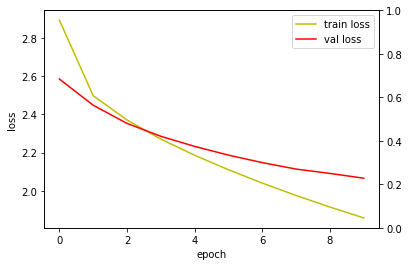

In [16]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='best')
plt.show()

### 평가하기

In [15]:
def generate_text(model, tokenizer, init_sentence='<start>', max_len=20):
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index['<end>']
    
    while True:
        predict = model(test_tensor)
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:,-1]
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break
        
    generated=""
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "
        
    return generated

In [18]:
# generate_text 함수에 ilove 로 시작되는 문장을 생성
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=50)

'<start> i love you , i m gonna be with you <end> '

In [19]:
generate_text(model, tokenizer, init_sentence="<start> you", max_len=50)

'<start> you re the only one who knows that you re a vegetable <end> '

### 최적의 하이퍼파라미터 적용하여 재학습
---
아래 4개의 하이퍼파라미터를 튜닝함. 최적값 도출 과정은 링크로 달아둠
1. Buffer_size : len(src_input) train_dataset 크기보다 10배 큰 값을 사용했을 때 overfitting을 효과적으로 억제할 수 있었지만, 학습 속도 측면을 고려해 기존 값인 len(src_input)을 사용 (train_dataset 크기보다 약간 큰 값).[링크](https://github.com/LubyJ/LubyJ/blob/master/EP06_buffer%20size%20tuning.ipynb)
2. Batch_size : 256 (512를 썼을 때 overfitting을 효과적으로 억제했지만, 학습속도가 느려서 256 사용) [링크](https://github.com/LubyJ/LubyJ/blob/master/EP06_batch%20size%20tuning.ipynb)
3. embedding_size : 128 [링크](https://github.com/LubyJ/LubyJ/blob/master/EP06_embedding%20size%20tuning.ipynb)
4. hidden_size : 512 [링크](https://github.com/LubyJ/LubyJ/blob/master/EP06_hidden%20size%20tuning.ipynb)

In [7]:
# train_dataset 객체 생성

BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256

VOCAB_SIZE = tokenizer.num_words + 1   

train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
val_dataset = val_dataset.shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [8]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()    
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self,x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    

embedding_size = 128
hidden_size = 512
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size) 

In [9]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                    reduction='none')
model.compile(loss=loss, optimizer=optimizer)
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
546/546 [==============================] - 74s 93ms/step - loss: 3.1454 - val_loss: 2.7230
Epoch 2/10
546/546 [==============================] - 54s 98ms/step - loss: 2.6053 - val_loss: 2.5317
Epoch 3/10
546/546 [==============================] - 54s 99ms/step - loss: 2.4651 - val_loss: 2.4354
Epoch 4/10
546/546 [==============================] - 54s 99ms/step - loss: 2.3691 - val_loss: 2.3609
Epoch 5/10
546/546 [==============================] - 54s 99ms/step - loss: 2.2913 - val_loss: 2.3031
Epoch 6/10
546/546 [==============================] - 54s 99ms/step - loss: 2.2239 - val_loss: 2.2574
Epoch 7/10
546/546 [==============================] - 55s 100ms/step - loss: 2.1632 - val_loss: 2.2186
Epoch 8/10
546/546 [==============================] - 55s 100ms/step - loss: 2.1071 - val_loss: 2.1842
Epoch 9/10
546/546 [==============================] - 55s 100ms/step - loss: 2.0548 - val_loss: 2.1564
Epoch 10/10
546/546 [==============================] - 55s 100ms/step - loss: 2

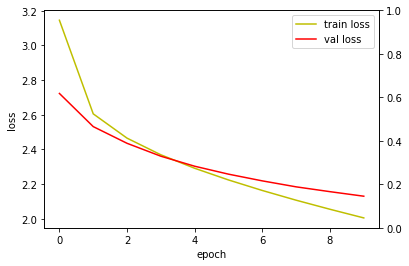

In [10]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='best')
plt.show()

* hypterparameter 조정을 통해 학습 속도를 1/3로 단축시킬 수 있었음.
* loss(2.0049)와 val_loss(2.1302)는 약 0.1가량 차이남.
* 정규화 방식을 도입해 재학습 시켜보자

### 각 RNN layer 뒤에 Dropout layer 추가(drop_rate=0.2)
---
* Dropout_rate이 너무 크면 underfitting 야기
* Dropout_rate이 너무 작으면 overfitting 야기
* 적절한 값을 찾는게 중요함

In [12]:
class TextGenerator2(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size, dropout_rate=0.2):
        super().__init__()    
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.dropout_1 = tf.keras.layers.Dropout(dropout_rate)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.dropout_2 = tf.keras.layers.Dropout(dropout_rate)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self,x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.dropout_1(out)
        out = self.rnn_2(out)
        out = self.dropout_2(out)
        out = self.linear(out)
        
        return out
    

embedding_size = 128
hidden_size = 512
model2 = TextGenerator2(tokenizer.num_words + 1, embedding_size , hidden_size) 

In [13]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                    reduction='none')
model2.compile(loss=loss, optimizer=optimizer)
history = model2.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
546/546 [==============================] - 58s 101ms/step - loss: 3.1785 - val_loss: 2.7830
Epoch 2/10
546/546 [==============================] - 55s 100ms/step - loss: 2.6737 - val_loss: 2.5882
Epoch 3/10
546/546 [==============================] - 55s 100ms/step - loss: 2.5451 - val_loss: 2.4986
Epoch 4/10
546/546 [==============================] - 55s 101ms/step - loss: 2.4661 - val_loss: 2.4315
Epoch 5/10
546/546 [==============================] - 55s 101ms/step - loss: 2.3954 - val_loss: 2.3677
Epoch 6/10
546/546 [==============================] - 55s 100ms/step - loss: 2.3296 - val_loss: 2.3144
Epoch 7/10
546/546 [==============================] - 55s 100ms/step - loss: 2.2709 - val_loss: 2.2692
Epoch 8/10
546/546 [==============================] - 55s 100ms/step - loss: 2.2174 - val_loss: 2.2329
Epoch 9/10
546/546 [==============================] - 55s 101ms/step - loss: 2.1677 - val_loss: 2.1979
Epoch 10/10
546/546 [==============================] - 55s 101ms/step - l

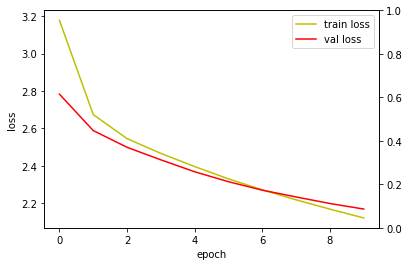

In [14]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='best')
plt.show()

* train과 val dataset 사이의 loss 값 차이가 많이 줄어들었으며, 학습속도도 개선됨.

In [18]:
generate_text(model2, tokenizer, init_sentence="<start> I love", max_len=50)

'<start> i love you , i m a little girl <end> '

In [19]:
generate_text(model2, tokenizer, init_sentence="<start> you re", max_len=50)

'<start> you re the only one who s the one <end> '

In [24]:
generate_text(model2, tokenizer, init_sentence="<start> If", max_len=50)

'<start> if you re a little bit of me <end> '

In [26]:
generate_text(model2, tokenizer, init_sentence="<start> when", max_len=50)

'<start> when i m in the club <end> '

# 회고

### A. 왜 데이터셋보다 많은 개수를 BUFFUER_SIZE로 설정했는가?
buffer size인 len(src_input)은 174738, src_input 데이터에서 train용과 validation용을 분리했기 때문에 학습에 사용되는 데이터셋은 139790개.

매 epoch마다 training 데이터를 buffer_size만큼 섞어서(shuffle) overfitting을 방지하기 위해 shuffle()을 사용하는데 데이터셋 갯수보다 큰 숫자를 buffer_size로 넣어준 이유는?

---
BUFFER_SIZE = len(src_input)<br>
dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))<br>
dataset = dataset.shuffle(BUFFER_SIZE)<br>
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)<br>

---

1. 'tf.data.Dataset.shuffle()' 사용 이유
    * dataset 내의 원소를 무작위로 섞어서 데이터의 고유한 순서나 패턴을 제거하기 위함.
    * 모델이 dataset에 있을 특정 시퀀스에 과적합 되는것을 방지하는데 도움을 줌.
    * 예제를 섞어줌으로써 모델은 훈련 중 더 다양한 예제 set를 접하게 되고, 접해보지 못한 데이터에도 범용적으로 사용할 수 있도록 함.
    
2. 'buffer_size'의 의미
    * dataset에서 무작위로 샘플링할 요소 수를 지정함.
    * buffer_size는 shuffle효과에 상당한 영향을 미칠 수 있음
    * buffer_size < len(dataset) 이라면, dataset의 하위 집합만 셔플에 사용되므로 편향되거나 불완전한 셔플이 발생할 수 있음. 
    * ordering 되어있거나 pattern이 있는 데이터셋 일부를 우연히 가져다가 학습에 사용되는 경우가 생길 수 있음. 그렇다면 섞어준다고 한들, 편향된 데이터셋을 가지고 학습하는 꼴이 됨.
    * buffer_size >> len(dataset) 이라면, 전체 데이터셋이 shuffle에 사용되므로 비효율적임.
    * buffer_size는 len(dataset)와 비슷한 값으로 설정해야함. __그러나,__ dataset이 너무 큰 경우 메모리 제약으로 인해 더 작은 buffer_size를 사용해야 할 수 있음.
    * 가장 좋은건, 다양한 buffer_size로 실험하고 훈련데이터에 대한 모델의 성능을 비교하여 최적의 값을 찾는게 제일 좋음.
    * model이 training data에 overfitting된 경우, buffer_size를 늘려 shuffle process에 더 많은 임의성을 도입해야 함.

### B. Batch_size가 성능에 미치는 영향은?

---
BATCH_SIZE = 256<br>
steps_per_epoch = len(src_input) // BATCH_SIZE<br>
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)<br>

---
1. 'tf.data.Dataset.batch(batch_size)' 란?
    * Epoch를 반복할 때, 한 epoch당 학습할 데이터 갯수를 지정함.
    * 한 번에 여러 example을 처리할 수 있으므로 training시간이 단축되고, 하드웨어 리소스를 더 잘 사용할 수 있음.

2. batch_size가 모델의 performance에 영향을 끼치는가?
    * 배치 크기는 속도와 정확도 측면에서 모델의 성능에 영향을 미침.
    * 더 큰 배치크기를 사용하면 모델이 더 많은 예제를 병렬로 처리할 수 있으므로, 학습 프로세스 __속도__ 가 빨라질 수 있음.
    * 그러나, 배치 크기가 클 수록 더 많은 메모리가 필요할 수 잇으므로 배치 크기와 하드웨어에서 사용 가능한 메모리 양 사이에 절충안을 찾아야 함.
    * __정확도__ 측면에서, 배치크기는 모델이 새 데이터에 얼마나 잘 일반화 되는지에 영향을 줄 수 있음. 
    * 배치 크기가 작을수록 모델이 매개변수를 더 자주 접할 수 있으므로 수렴 속도가 빨라지나, 작을수록 학습 프로세스에 더 많은 노이즈가 발생해 모델이 좋은 솔루션으로 수렴하기 어려움.
    * 배치 크기가 크면 노이즈를 줄일 수 있지만, 모델이 최적값이 아닌 곳으로 수렴될 수 있음.
    * 실제로 최적의 배치 크기는 사용 중인 특정 데이터 세트, 모델 아키텍처 및 하드웨어에 따라 다름. 다양한 배치 크기로 실험하고 검증 세트에서 모델의 성능을 모니터링하여 최상의 값을 결정하는 것이 좋음

### C. LSTM layer가 무엇인가?
* LSTM 은 Long Short-Term Memory의 약어로, recurrent neural network layer의 한 종류임.
* NLP, 번역, 시계열 분석같은 시퀀스 모델링에 주로 사용됨.
---
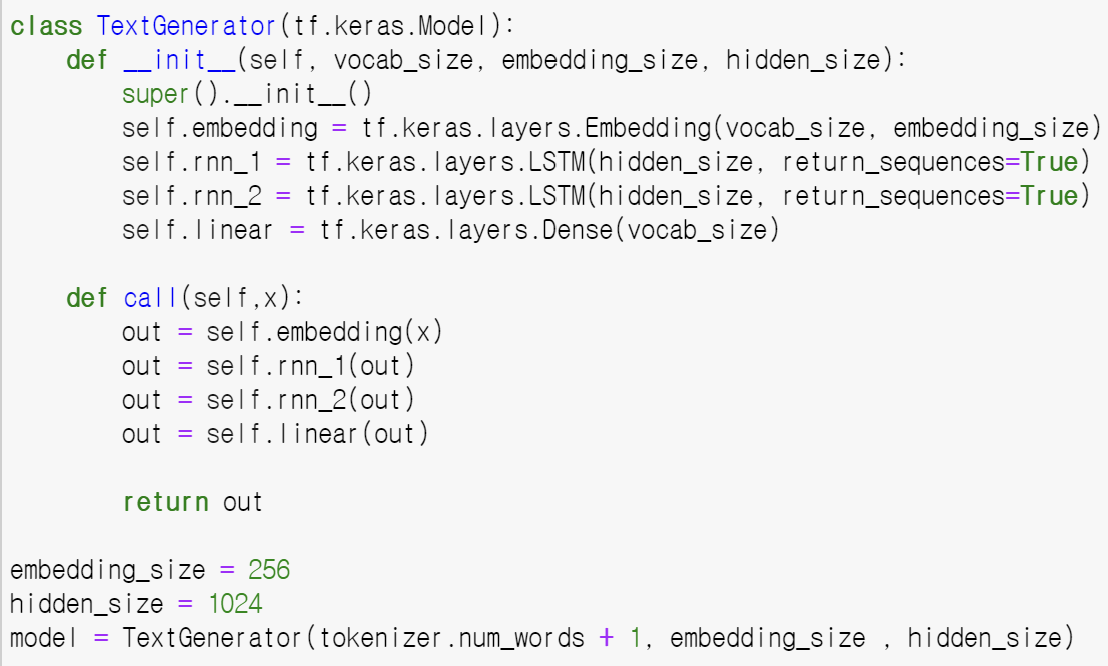

---


1. LSTM의 목적?
    * long-term dependencies를 추출하는 것
    * long term dependencies란? 시간 단계로 구분되는 시퀀스의 요소 간 관계를 나타냄. 예를 들어 자연어 처리에서 단어나 구 사이의 연관성.
    * 메모리 셀과 일련의 게이트를 사용하여 이전 시간 단계의 정보를 선택적으로 업데이트하고 잊어버림으로써 long-term dependencies를 추출함.<br>
    <br>
2. LSTM layer의 구성은?
    * LSTM layer는 정보의 흐름을 제어하는 3개의 gate로 이루어짐. input gate, forget gate, output gate.
    * input gate : cell state에 얼만큼의 새로운 정보를 추가할것인지를 controll
    * forget gate : cell state에서 얼마나 오래된 정보를 버릴것인지를 조절
    * output gate : cell state에서 몇개의 정보를 다음 time step으로 넘길것인지를 조절.
   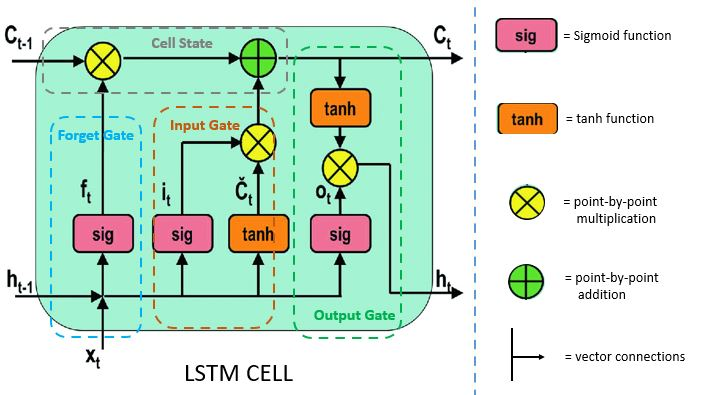
   [출처](https://www.pluralsight.com/guides/introduction-to-lstm-units-in-rnn)<br>
<br>
3. LSTM 성능을 개선하기 위한 파라미터는?
    * hidden_state의 size, 신경망의 깊이에 의해 결정됨
    * 너무 얕은 신경망으로 구성되어 있거나 너무 작은 hidden_units(size)를 사용하면  복잡한 long-term dependencies를 추출할 수 없음
    * 너무 깊은 신경망으로 구성되어 있거나, 너무 큰 hidden_units(size)를 사용하면 vanishing gradients 문제나 overfitting 문제가 발생함

### D. Embedding_size와 hidden_size의 역할은?

* 둘 다 신경망에서 사용되는 벡터 표현의 크기를 정의하는 하이퍼파라미터

1. embedding_size?<br>
    * 한 단어를 얼마나 조밀한 혹은 느슨한 벡터로 표현할 것인가를 지정
    * 단어의 의미나 다른 단어 혹은 문장 사이의 연관성(문맥)을 연속적인 vector space에 저장함.
    * 만약 embedding size를 2로 지정하면, 모든 단어는 2차원 벡터로 표현됨. 이러한 펙터들은 2D plane에 점으로 시각화한다면. __비슷한 의미__ 를 갖는 단어나 문장은 __가까운 위치__ 에 모여있고, 다른 의미를 갖는 단어나 문장은 멀리 위치해 있음.
    * one-hot vector 처럼 0, 1로 표현하지 않고 embedding vector로 표현하면 더 효율적으로 text data를 학습하고 단어 사이의 복잡한 관계성도 continuous vector space에서 찾아낼 수 있음.<br>
<br>

2. embedding_size가 모델의 성능에 끼치는 영향?<br>
    * 작은 값을 사용하면 텍스트 데이터의 뉘앙스를 잘 표현하지 못하고, 정확도가 떨어짐.
    * 큰 값을 사용하면 overfitting문제가 발생함.<br>
<br>
3. hidden_size?<br>
    * LSTM layer내 hidden_layer의 hidden units(?)를 나타내는 하이퍼파라미터
    * 모델의 복잡도(complexity)와 long-term dependencies를 추출하는 역할을 함.
    * hidden_size가 클수록, 데이터 내의 더 복잡한 패턴을 학습할 수 있지만, training data보다 훨씬 큰 값을 설정할 경우 overfitting 문제를 야기할 수 있음.

### E. 하이퍼파라미터 조절 이후
* 하이퍼파라미터를 조절하여 학습 속도를 개선시키고 overfitting을 어느정도 방지할 수 있었음.
* 하이퍼파라미터 최적화 이후에도 overfitting이 감소하지 않는다면, dropout, batchnormalization 등 정규화 방법을 도입하면 overfitting 정도를 더욱 낮출 수 있음.